# **Final Report: Predicting a Player's PLAICraft Newsletter Subscription Status by Age and Playtime**

## **Introduction**
As part of a data-collection initiative by the Pacific Laboratory for Artificial Intelligence (PLAI), PLAICraft is a free-use Minecraft server whose goal is to record over 10,000 hours of multiplayer gameplay (Plaicraft.ai , 2023). One challenge in amassing such large amounts of data is ensuring the pubic remains engaged with the server. As follows, a game-related newsletter was developed to provide players with regular reminders, thereby encouraging continued participation.

However, to fully optimize recruitment efforts, it is necessary to understand which player characteristics are most predictive of subscribing to the PLAICraft newsletter. Therefore, this report seeks to answer the following fundamental question: *Can a player’s age and total playtime predict their likelihood of subscribing to the PLAICraft newsletter?* <!-- reword this later-->

<!-- mention methodology? -->

### **Dataset Overview**
This project utilizes the `players.csv` dataset, which contains information on 196 (observations) individual players who have participated in the PLAICraft server. As detailed in Table 1, `players.csv` includes 7 variables.

<p style="text-align: center; font-weight: bold;">Table 1. Variables in <code> players.csv </code> </p> <!-- in-line code or no in-linecode -->

| Name                  | Type         | Description                                                                                     |
|-----------------------|--------------|-------------------------------------------------------------------------------------------------|
| `experience`          | character    | Player’s declared experience level.  <br> (One of `Amateur`, `Regular`, `Pro`, or `Veteran`.)   |
| `subscribe`           | logical      | Indicates the player's newsletter subscription status. <br> (`TRUE` if subscribed, `FALSE` if not subscribed.)                                                                                                                                                                                      |
| `hashedEmail`         | character    | Player's encrypted email address.                                                               |
| `played_hours`        | double       | Total number of hours played on PLAICraft.                                                      |
| `name`                | character    | Player’s username.                                                                              |
| `gender`              | factor       | Player's gender. <br> (One of `Female`, `Male`, `Non-Binary`, `Prefer not to say`.)             |
| `Age`                 | integer      | Player’s age                                                                                    |

## **Methodology**


In this report, we use `played_hours` and `age` as predictor variables for our target variable, newsletter subscription (`subscribe`) status. Specifically, we will construct a *k*-Nearest Neighbours (kNN) classification model. To achieve this, `players.csv` will be wrangled, and preliminary analysis will be conducted to gauge summary statistics of the relevant variables. Data will normalized before being split into training and testing sets. We will then use 5-fold cross validation to determine the best value of *k* to pursue.

### **Reading in Data**

Begin by importing all necessary packages. The `tidyverse` and `tidymodels` packages mainly provide functions for data wrangling, data visualization, and modelling. We also use `themis` to address class imbalance during model training. A fixed seed is specified to ensure any randomness (e.g. training-testing splits) remains reproducible.

In [1]:
library(tidyverse)
library(tidymodels)
library(themis)

set.seed(118)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

`players.csv` is read using `read_csv()`.

In [2]:
raw_players <- read_csv("data/players.csv")
head(raw_players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


**Table 2. Raw `players.csv` dataset**: A preview of the raw `players.csv` dataset obtained from PLAICraft.

### **Data Wrangling**


To prepare the dataset for kNN classification, we perform the following data wrangling steps:

1. `rename()` the `hashedEmail` and `Age` columns to ensure consistency.

2. `select()` relevant predictor variables (`age` and `played_hours`) and the target variable (`subscribe`).

3. Using `drop_na()`, remove rows containing missing values (`NA`), assuming these values are randomly distributed and non-informative (Timbers et al., 2024).

4. Using `mutate()` and `as_factor()`, convert the `subscribe` column from a logical to a factor data type, which is required for classification.

5. Use `fct_recode()` to relabel `TRUE`/`FALSE` to `"YES"`/`"NO"`, respectively, for better interpretability.


In [3]:
players <- raw_players |>
    rename("hashed_email" = "hashedEmail", "age" = "Age") |>
    select(age, played_hours, subscribe) |>
    drop_na() |>
    mutate(subscribe = as_factor(subscribe)) |>
    mutate(subscribe = fct_recode(subscribe, "Yes" = "TRUE", "No" = "FALSE"))
head(players)

age,played_hours,subscribe
<dbl>,<dbl>,<fct>
9,30.3,Yes
17,3.8,Yes
17,0.0,No
21,0.7,Yes
21,0.1,Yes
17,0.0,Yes


**Table 3. Wrangled `players.csv` dataset**: Preview of the final wrangled data used later for modelling.

### **Summary Statistics & Data Exploration**


Before kNN analysis, we compute summary statistics on the processed `players.csv` dataset (now called `players`). This allows us to better understand the structure and distribution of the continuous variables. Specifically, we compute the minimum, maximum, and mean values of both `age` and `played_hours`. Additionally, we report the total observation count, which represents the number of unique players in this dataset.

In [4]:
players_summary <- players |>
    summarize(observation_count = n(),
    	      min_age = min(age), 
    	      max_age = max(age),
    	      mean_age = mean(age),
              min_hours = min(played_hours),
    	      max_hours = max(played_hours),
    	      mean_hours = mean(played_hours))
players_summary

observation_count,min_age,max_age,mean_age,min_hours,max_hours,mean_hours
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
194,8,50,20.52062,0,223.1,5.904639


**Table 4. Summary statistics on predictor variables:** This table presents descriptive statistics for the predictor variables `age` and `played_hours`.

Table 4 indicates a disparity between the `age` and `played_hours` variables. While `age` ranges from 8 to 50 (years), `played_hours` spans a much wider range, from 0 to over 233 (hours). Because the kNN algorithm classifies observations based on Euclidean distance, predictors with larger numerical ranges and values disproportionately influence kNN calculations. Without standardization, `played_hours` would dominate the algorithm and lessen the weight of `age`, which may not accurately reflect the true relationship between these features and whether a player subscribes to the newsletter.

Additionally, we notice that there are now 194 observations rather than 196 (refer to Introduction). Therefore, 2 observations were dropped due to missing values, as stated in the section on data wrangling.

Then, to explore the relationship between the variables, we generate a scatter plot comparing `hours` vs. `age`, where each observation is coloured by subscription status.

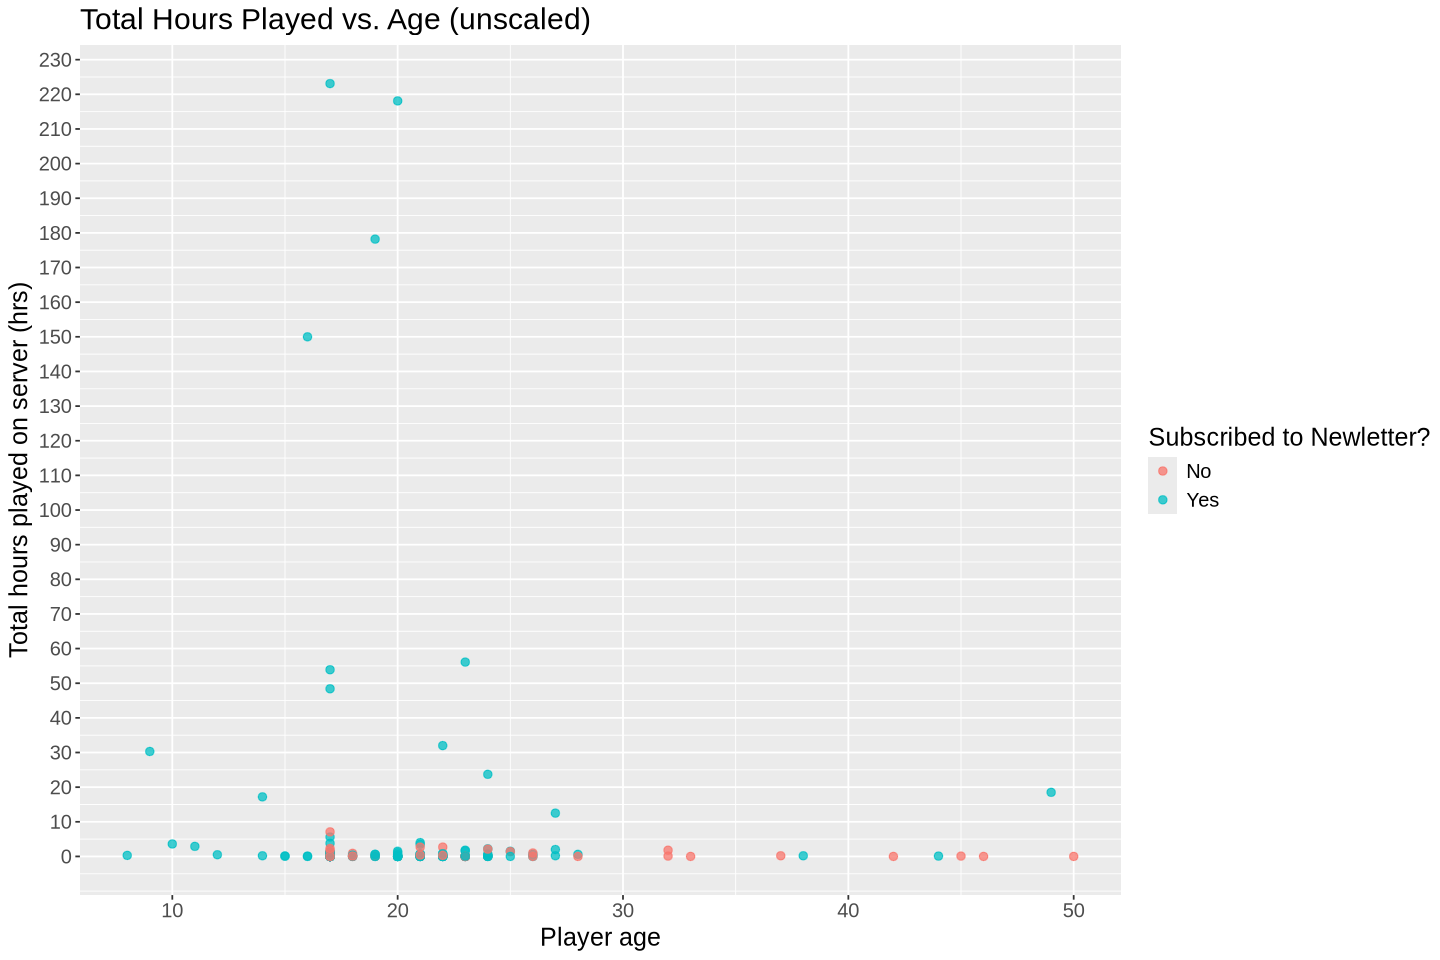

In [5]:
options(repr.plot.width = 12, repr.plot.height = 8) # Set Graph Size

age_v_hour <- players |>
    ggplot(aes(x = age, y = played_hours, colour = subscribe)) +
    geom_point(alpha = 0.75, size = 2) +
    xlab("Player age") +
    ylab("Total hours played on server (hrs)") +
    theme(text = element_text(size = 15)) +
    labs(colour = "Subscribed to Newletter?") +
    scale_y_continuous(breaks = seq(0, 250, by = 10)) +   # Show Tick by 10 on y-axis       
    ggtitle("Total Hours Played vs. Age (unscaled)")
age_v_hour

**Figure 1. Total Hours Played vs. Age (unscaled):** This plot visualizes the relationship between a player's age and total hours played on the PLAICraft server. Each point represents an individual player, with color indicating whether they subscribed to the newsletter.

From this visualization, we can see that the predictors are disproportionate. This reaffirms our observation that the variables will require nomalization prior to training the model.

Lastly, to better understand the distribution of the response variable, we calculate the number and percentage of observations in each class of the `subscribe` variable. We count how many players are subscribed (Yes) versus not subscribed (No) and compute the relative proportions of each group.

In [6]:
total_number_of_observations <- nrow(players)
players_classes <- players |>
	group_by(subscribe) |>
	summarize(count = n(),
		      percentage = n() / total_number_of_observations * 100)
players_classes

subscribe,count,percentage
<fct>,<int>,<dbl>
No,52,26.80412
Yes,142,73.19588


**Table 5. Summary statistics on response variable:** This table presents descriptive statistics for the response variable `subscribe`.

Table 5 indicates a substantial difference between the amount of subscribed and non-subscribed players. This class imbalance poses an issue for the kNN algorithm, which classifies observations by majority class among its *k* closest neighbours. The model may be biased towards the dominating class, leading to inaccurate predictions. (We would expect the algorithm to return `Yes` more frequently simply because there are more `Yes` points.)

### **Data Splitting, Normalization, & Initial Modeling**

To prepare the data for kNN classification, we split the wrangled `players` dataset into training and testing sets using an 80/20 ratio, respectively. As such, 80% of the observations form the training set used to fit and tune the model, while the remaining 20% are kept separated as unseen data for final evaluation. We pass the response variable into the stratified sampling argument to ensure that the class proportions (Yes vs. No) are maintained in both sets.

In [7]:
### Create an 80/20 training/testing data split
players_split <- initial_split(players, prop = 0.80, strata = subscribe)
players_train <- training(players_split)
players_test <- testing(players_split)

We then define a training recipe, which specifies both the response variable and the predictor variables used to build the model. Part of creating the recipe is to address the differences in scale observed between the predictor variables (Table 4) by centering and scaling them. Centering subtracts the mean of each variable from each of its values, shifting the distribution so that it is centered around 0. This prevents variables with higher mean values from disproportionately influencing distance calculations. Scaling then divides each centered value by the variable’s standard deviation, standardizing the spread so that all variables have a standard deviation of 1. This ensures that variables with larger variance (`played_hours`) do not dominate the distance metric used by the kNN algorithm.

Additionally, to address the class imbalance shown in the response variable (Table 5), we use the `step_upsample()` function to randomly oversample the minority class (No) in the training set. This process involves duplicating existing observations from the minority class until both classes are approximately equal.

In [8]:
### Training recipe
players_recipe <- recipe(subscribe ~ ., data = players_train) |>
    step_center(all_predictors()) |> # centre data
    step_scale(all_predictors()) |> # scale data
    step_upsample(subscribe, over_ratio = 1, skip = TRUE) 
    # skip is set to TRUE, since we only want to oversample on training folds

We then specify that we are using the kNN model. The model is defined using the `nearest_neighbor()` function, where the number of neighbors *k* is set to `tune()`. This allows the parameter *k* to be optimized during the tuning process. We also set `weight_func = "rectangular"` so that all neighbours are weighted equally when making predictions.

In [9]:
### Specify the tuning model
training_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

### **Determining *k***

Now, we determine the optimal *k* for the kNN classifier by tuning via cross-validation. We begin by setting up 5-fold cross validation on the training data using `vfold_vc()` and set `strata = subscribe` to preserve the class proportions in each fold. Thereby, the data will be split into five equal folds, with the model trained on four and validated on the remaining one. This repeats five times, so each fold serves as the validation set once. This is done to reduce the potential bias caused by a single random training-testing split.

In [10]:
players_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)

We then define a range of candidate *k* values, ranging from 1 to 100 in increments of 5. 

In [11]:
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

Next, we create a workflow of our model using the `workflow()` function. This combines the previously defined recipe (`players_recipe`) and model specification (`training_spec`). This workflow is passed to the function `tune_grid()`, which trains and evaluates the model for each candidate *k* in `k_vals` using 5-fold cross validation. During this process, we calculate several performance metrics, including accuracy, recall, and precision. These metrics are stored in `knn_results`.

In [12]:
knn_results <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(training_spec) |>
    tune_grid(resamples = players_vfold,
              grid = k_vals,
              metrics = metric_set(accuracy, recall, precision)) |>
    collect_metrics() 
head(knn_results)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.4991398,5,0.036482209,Preprocessor1_Model01
1,precision,binary,0.2430392,5,0.040994111,Preprocessor1_Model01
1,recall,binary,0.4638889,5,0.107457284,Preprocessor1_Model01
6,accuracy,binary,0.4672849,5,0.030422804,Preprocessor1_Model02
6,precision,binary,0.2771033,5,0.008914318,Preprocessor1_Model02
6,recall,binary,0.6333333,5,0.088780316,Preprocessor1_Model02


**Table 6. Performance metrics of candidate *k* values:** This table previews the several performance metrics collected for each candidate *k* value in the specified range.

To better understand the metric trends with *k*, we plot the performance curves for accuracy, recall, and precision, respectively, as seen in Figure 2.

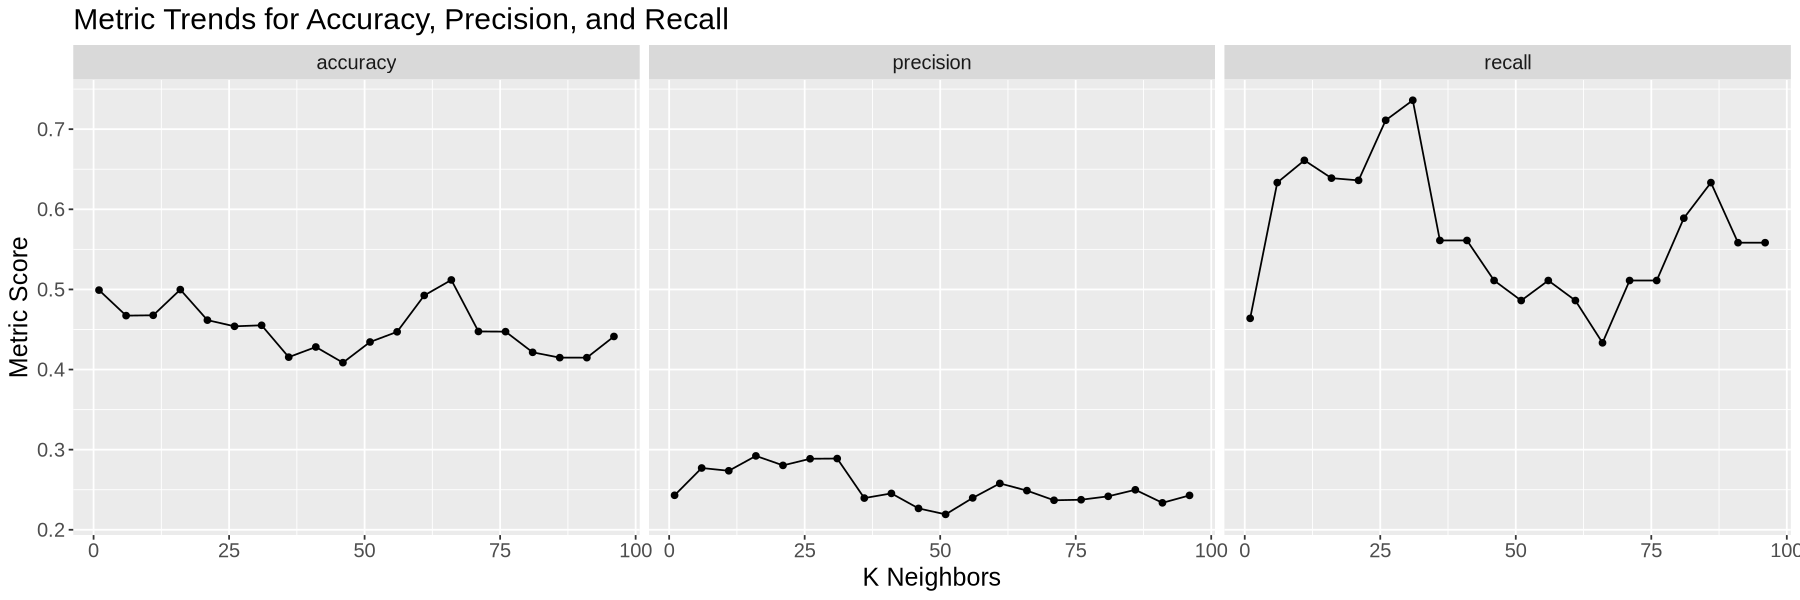

In [21]:
options(repr.plot.width = 15, repr.plot.height = 5)
metric_trends <- knn_results|>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    facet_wrap(facets = vars(.metric)) +
    ylab("Metric Score") +
    xlab("K Neighbors") +
    ggtitle("Metric Trends for Accuracy, Precision, and Recall") + 
    theme(text = element_text(size = 15))
metric_trends

**Figure 2. Metric Trends for Accuracy, Precision, and Recall:** This figure displays how the performance of the kNN model varies with different values of *k* measured using three metrics: accuracy, precision, and recall. Each subplot shows the trend of one metric as *k* increases from 1 to 100.

We then extract the optimal value of *k* for each metric, selecting the number of neighbours that produces the highest mean score across the folds.

In [13]:
### Find best K for Accuracy, Precision, and Recall.
optimal_k_df <- knn_results |>
    group_by(.metric) |>
    slice_max(mean, n = 1) |>
    select(.metric, neighbors, mean)
optimal_k_df

.metric,neighbors,mean
<chr>,<dbl>,<dbl>
accuracy,66,0.5118280
precision,16,0.2922148
recall,31,0.7361111


**Table 7. Optimal *k* value for each evaluation metric:** This table reports the optimal value for *k* when evaluated for accuracy, precision, and recall, respectively.

Finally, we isolate the *k* value that maximizes accuracy. As seen in Table 7, here we select $k = 66$.

In [14]:
optimal_k_accuracy <- optimal_k_df |>
    ungroup() |>
    filter(.metric == "accuracy") |>
    select(neighbors) |>
    pull()

### **Training, Testing, & Evaluating Accuracy**

To produce the finalized kNN model, `knn_spec`, we specify `neighbors = optimal_k_accuracy`. This sets the argument to the best-performing *k* value as determined above (based on accuracy).

In [15]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = optimal_k_accuracy) |>
    set_engine("kknn") |>
    set_mode("classification")

We then build a new workflow by comibining the new `knn_spec` with the training recipe used earlier. The model is then fit to the entire training dataset (without cross-validation folds) using `fit(data = players_train)`.

In [16]:
knn_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_spec) |>
    fit(data = players_train)

Once the final model is trained, we generate predictions on the test set with `predict(knn_fit, players_test)` and bind those predictions to the actual outcomes using `bind_cols()`, allowing us to directly compare the predicted and true values of the `subscribe` variable.

In [17]:
players_test_predictions <- predict(knn_fit, players_test)|>
    bind_cols(players_test)

To evaluate our model's performance, we calculate three fundamental metrics:
- Accuracy: the proportion of overall correct predictions
- Precision: the proportion of predicted subscribers that were indeed subscribers
- Recall: the proportion of how many actual subscribers were correctly identified

Note: We are treating the "Yes" class in `subscribed` as the positive class.

In [18]:
players_test_metrics <- bind_rows(
    players_test_predictions |>
        metrics(truth = subscribe, estimate = .pred_class) |>
        filter(.metric == "accuracy"),
    
    players_test_predictions |>
        precision(truth = subscribe, estimate = .pred_class, event_level = "first"),
    
    players_test_predictions |>
        recall(truth = subscribe, estimate = .pred_class, event_level = "first"))
players_test_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6750000
precision,binary,0.4583333
recall,binary,1.0000000


**Table 8. Performance metrics on the testing set:** This table summarizes the performance of the finalized kNN model when evaluated on the test set across accuracy, precision, and recall, respectively.

Lastly, a confusion matrix is generated using `conf_mat()`, providing a full summary of the true positives, true negatives, false positives, and false negatives. The matrix reveals that while all actual subscribers ("Yes") were correctly identified (high recall), the model also misclassified 11 non-subscribers as subscribers, leading to a lower precision score.

In [19]:
confusion_matrix <- players_test_predictions |>
    conf_mat(truth = subscribe, estimate = .pred_class)
confusion_matrix

          Truth
Prediction No Yes
       No  11  13
       Yes  0  16

**Table 9. Confusion matrix of test set predictions:** This confusion matrix provides a detailed breakdown of the model's classification outcomes on the test set. The rows represent the predicted values, while the columns represent the actual (true) values.

After evaluating the model on the test data, we proceed to fit the final kNN model to the entire dataset, `players`. We then generate predictions for every observation in the original dataset using predict and attach these predicted labels to the original data.

In [20]:
players_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_spec) |>
    fit(data = players)

players_predictions <- predict(players_fit, players) |>
    bind_cols(players) |>
    select(age, played_hours, subscribe, .pred_class) # reorder columns

head(players_predictions)

age,played_hours,subscribe,.pred_class
<dbl>,<dbl>,<fct>,<fct>
9,30.3,Yes,Yes
17,3.8,Yes,Yes
17,0.0,No,Yes
21,0.7,Yes,Yes
21,0.1,Yes,Yes
17,0.0,Yes,Yes


**Table 10. Predicted vs. actual subscription status:** This table displays some of the model’s predicted subscription status (`.pred_class`) alongside the actual subscription labels (`subscribe`).

---

## **Discussion**

In this project, we set out to determine whether a player’s age and hours played could predict whether they subscribe to the PLAICraft newsletter.  Our work involved data wrangling, exploratory data analysis, visualization, and k-Nearest Neighbors (kNN) classification modeling to investigate relationships in the dataset.

### **Summary of Findings**

After cleaning the dataset and addressing issues like missing values and class imbalance, we focused on predicting subscription status using `age` and `played_hours` as predictors. We observed a class a difference in scale and class imbalance where a majority of players were subscribed (73%), which would have influenced the model's performance and required upsampling of the minority class.

The kNN model performed best with *k* = 66 neighbours (when prioritizing accuracy), achieving the following performances on the test set:
* **Accuracy**: 72.5%
* **Precision**: 50.0%
* **Recall**: 100.0%

These results suggest the model is very effective at identifying actual subscribers (high recall) but is more error-prone in predicting non-subscribers (lower precision). This was confirmed by the confusion matrix in Table 9.

### **Expectations vs. Reality**

We expected that `played_hours` would be a strong predictor due to its wide range and potential to reflect player engagement. This was supported by the data, as played hours contributed heavily to the model’s predictions. However, due to the disproportionate scales of age (8–50 years) and played_hours (0–233 hours), normalization was critical—otherwise, the distance-based nature of kNN would have skewed toward played_hours. The strong performance in recall supports the idea that highly engaged players (likely experienced ones) are more often subscribers.

### **Potential Impact**

These findings have several implications. First, they demonstrate that engagement metrics like playtime, when normalized and modelled appropriately, can help predict subscription behaviour. This could be valuable for game developers or marketers aiming to target certain user segments for promotions or subscriptions.
Secondly, the fact that age was less impactful compared to played_hours might suggest that engagement is less age-dependent, which is useful information when designing features or subscription models aimed at different demographics.

### **Future Questions**

This analysis opens the door to several future questions:
1. Can we predict a player’s experience level based on age and hours played?
2. How can we improve precision while maintaining high recall?
3. Would adding variables like experience or gender improve model balance and precision?
   
---

## **References**

plaicraft.ai . (2023, September 27). PLAI. https://plai.cs.ubc.ca/2023/09/27/plaicraft/

Timbers, T., Campbell, T., & Lee, M. (2024). Data Science. In datasciencebook.ca. CRC Press/Taylor & Francis. https://datasciencebook.ca/index.html

---